### Simulation
expanding to four distinct epilepsy types will make your dataset much more realistic and scientifically valuable.
We’ll simulate four clinical manifestations, each with a unique temporal and spectral pattern inspired by neurological descriptions:

Label	Seizure Type	Motion Pattern (Simulation Description)
0	Tonic–Clonic	Rhythmic 3–5 Hz oscillations with medium amplitude (shaking)
1	Myoclonic	Sudden, shock-like jerks (1–3 sharp spikes)
2	Atonic	Loss of muscle tone → near-flat signal with slow drifts
3	Absence	Subtle rhythmic 1–2 Hz small-amplitude waves (brief lapses)


| Type             | Physiological behavior                                                        | Simulation improvement                                                                                   |
| ---------------- | ----------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------- |
| **Tonic–Clonic** | Alternating tonic (stiff) and clonic (rhythmic jerks, 3–5 Hz) phases          | amplitude-modulated burst pattern with irregular intervals, partial pauses, and multi-frequency blending |
| **Myoclonic**    | Sudden, brief jerks                                                           | keep short impulses with random amplitude and channel variation                                          |
| **Atonic**       | Loss of tone                                                                  | keep slow drift and flattening                                                                           |
| **Absence**      | Brief lapses of awareness; small head or eye movements (~2–4 Hz, short burst) | add small, low-amp oscillations with random noise, amplitude modulation, and occasional micro-jerks      |



In [7]:
import numpy as np, os

# ---------- Utility ----------
def rand_phase_noise(t, base_freq, jitter=0.3):
    """Generate slightly irregular phase for frequency drift."""
    phase = 2 * np.pi * base_freq * t
    phase += np.cumsum(np.random.randn(len(t)) * jitter * (t[1]-t[0]))
    return np.sin(phase)

# ---------- 1. Realistic Tonic–Clonic ----------
def simulate_tonic_clonic_real(n, T=128, C=9, fs=50):
    X = []
    for _ in range(n):
        t = np.linspace(0, T/fs, T)
        freq = np.random.uniform(3,5)
        base = rand_phase_noise(t, freq)
        # amplitude modulation: 0–1 bursts
        amp_env = (np.sin(2*np.pi*np.random.uniform(0.3,0.6)*t)+1)/2
        amp_env = np.clip(amp_env + 0.3*np.random.randn(*t.shape), 0, 1.2)
        sample = np.array([
            0.6*amp_env*rand_phase_noise(t, freq+np.random.uniform(-0.5,0.5))
            + 0.15*np.random.randn(T)
            for _ in range(C)
        ]).T
        # random axis dominance (simulate orientation)
        sample *= np.random.uniform(0.8, 1.2, (1,C))
        X.append(sample)
    return np.stack(X)

# ---------- 2. Myoclonic (same as before, good realism) ----------
def simulate_myoclonic_real(n, T=128, C=9):
    X = []
    for _ in range(n):
        sample = 0.05*np.random.randn(T, C)
        n_spikes = np.random.randint(1, 4)
        for _ in range(n_spikes):
            center = np.random.randint(10, T-10)
            width = np.random.randint(1, 3)
            amp = np.random.uniform(1.5, 3.0)
            spike = amp * np.exp(-0.5*((np.arange(T)-center)/width)**2)
            sample += spike[:, None]*(np.random.randn(C)*0.4 + 1)
        X.append(sample)
    return np.stack(X)

# ---------- 3. Atonic (flat with low drift) ----------
def simulate_atonic_real(n, T=128, C=9):
    X = []
    for _ in range(n):
        t = np.linspace(0, 2*np.pi, T)
        drift = 0.05*np.sin(0.3*t + np.random.rand())
        sample = np.array([
            drift + 0.03*np.random.randn(T)
            for _ in range(C)
        ]).T
        X.append(sample)
    return np.stack(X)

# ---------- 4. Realistic Absence ----------
def simulate_absence_real(n, T=128, C=9, fs=50):
    X = []
    for _ in range(n):
        t = np.linspace(0, T/fs, T)
        freq = np.random.uniform(2, 4)
        base = 0.2*rand_phase_noise(t, freq)
        amp_mod = 0.5 + 0.5*np.sin(2*np.pi*np.random.uniform(0.1,0.3)*t)
        noise = 0.05*np.random.randn(T)
        microjerk = np.zeros_like(t)
        if np.random.rand() < 0.4:
            j_idx = np.random.randint(10, T-10)
            microjerk[j_idx:j_idx+2] = np.random.uniform(0.4, 0.8)
        sample = np.array([
            amp_mod*(base + noise + microjerk)
            for _ in range(C)
        ]).T
        X.append(sample)
    return np.stack(X)

# ---------- Combine & Save as UCI-style ----------
def generate_epilepsyHAR_realistic(root="EpilepsyHAR_Realistic", n_each=250, train_ratio=0.8):
    os.makedirs(os.path.join(root, "train", "Inertial Signals"), exist_ok=True)
    os.makedirs(os.path.join(root, "test", "Inertial Signals"), exist_ok=True)

    X_tonic = simulate_tonic_clonic_real(n_each)
    X_myoc  = simulate_myoclonic_real(n_each)
    X_aton  = simulate_atonic_real(n_each)
    X_abs   = simulate_absence_real(n_each)

    X = np.concatenate([X_tonic, X_myoc, X_aton, X_abs], axis=0)
    y = np.concatenate([
        np.zeros(n_each, dtype=int),
        np.ones(n_each, dtype=int),
        np.full(n_each, 2, dtype=int),
        np.full(n_each, 3, dtype=int)
    ])

    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    n_train = int(len(X)*train_ratio)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test,  y_test  = X[n_train:], y[n_train:]

    signal_names = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_"
    ]
    def save_signals(Xset, yset, split):
        sig_dir = os.path.join(root, split, "Inertial Signals")
        for c, name in enumerate(signal_names):
            np.savetxt(os.path.join(sig_dir, f"{name}{split}.txt"), Xset[:,:,c], fmt="%.6f")
        np.savetxt(os.path.join(root, split, f"y_{split}.txt"), yset, fmt="%d")

    save_signals(X_train, y_train, "train")
    save_signals(X_test,  y_test,  "test")

    print(f"✅ Generated more realistic Epilepsy HAR dataset at {root}/")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print("Labels: 0=Tonic-Clonic, 1=Myoclonic, 2=Atonic, 3=Absence")

# --- Run once ---
generate_epilepsyHAR_realistic("EpilepsyHAR_Realistic", n_each=250)


✅ Generated more realistic Epilepsy HAR dataset at EpilepsyHAR_Realistic/
Train: (800, 128, 9), Test: (200, 128, 9)
Labels: 0=Tonic-Clonic, 1=Myoclonic, 2=Atonic, 3=Absence


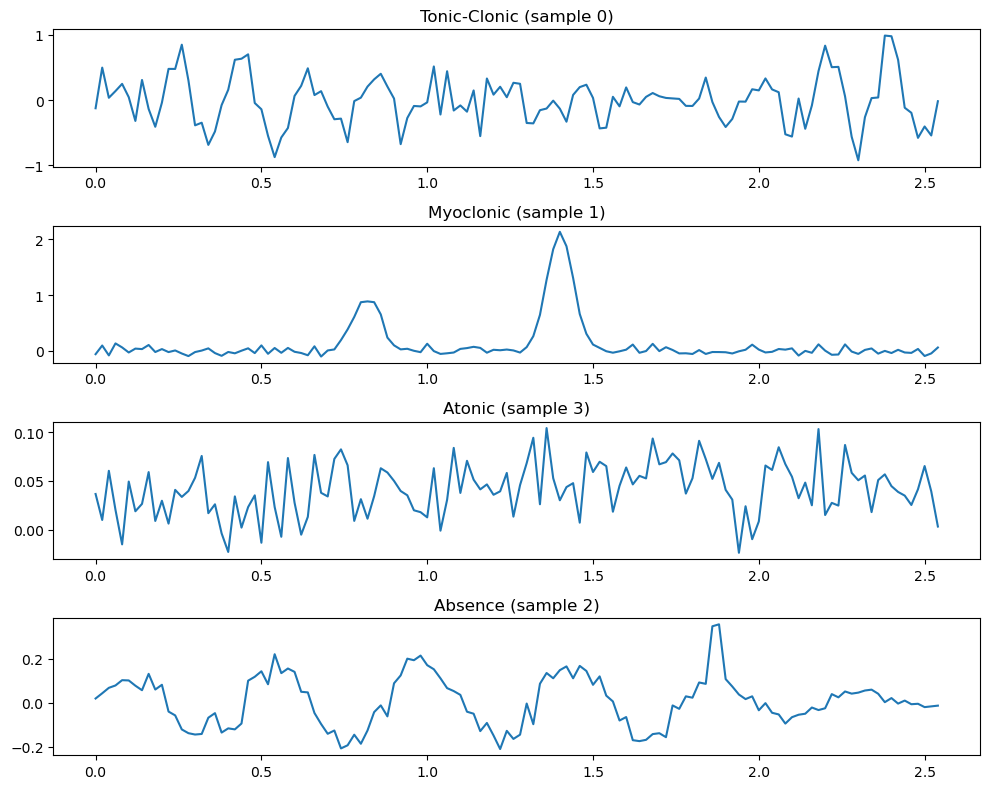

In [8]:
import matplotlib.pyplot as plt
import numpy as np, os

root = "EpilepsyHAR_Realistic"
y = np.loadtxt(os.path.join(root, "train", "y_train.txt")).astype(int)
sig = np.loadtxt(os.path.join(root, "train", "Inertial Signals", "total_acc_x_train.txt"))
classes = ["Tonic-Clonic", "Myoclonic", "Atonic", "Absence"]
fs=50

fig, axes = plt.subplots(4,1, figsize=(10,8))
for i in range(4):
    idx = np.where(y==i)[0][0]
    t = np.arange(sig.shape[1])/fs
    axes[i].plot(t, sig[idx])
    axes[i].set_title(f"{classes[i]} (sample {idx})")
plt.tight_layout(); plt.show()


Loaded: (800, 128, 9) Labels: [208 194 200 198]


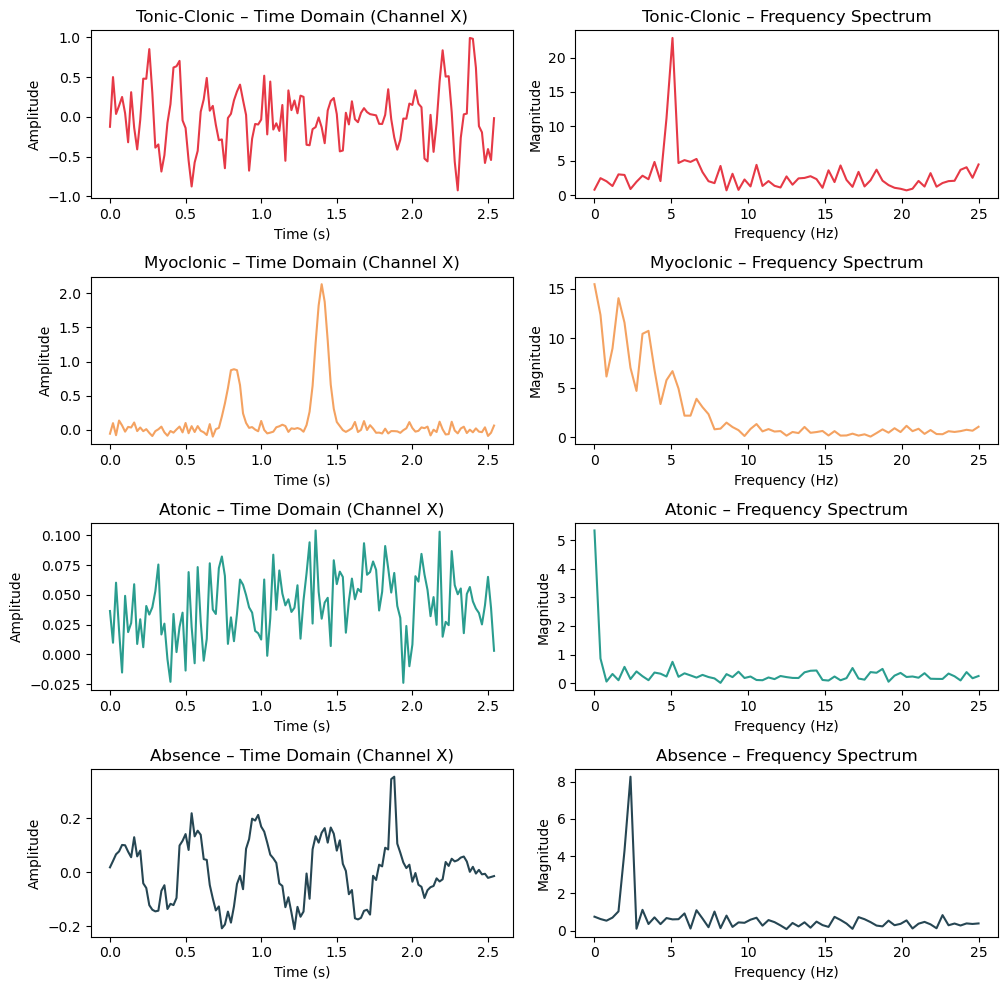

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Load dataset from EpilepsyHAR directory ---
root = "EpilepsyHAR_Realistic"
signal_names = [
    "total_acc_x_", "total_acc_y_", "total_acc_z_",
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_"
]

def load_split(root, split="train"):
    folder = os.path.join(root, split, "Inertial Signals")
    arrays = [np.loadtxt(os.path.join(folder, f"{s}{split}.txt")) for s in signal_names]
    data = np.stack(arrays, axis=-1)  # [N, T, 9]
    labels = np.loadtxt(os.path.join(root, split, f"y_{split}.txt")).astype(int)
    return data, labels

X_train, y_train = load_split(root, "train")
print("Loaded:", X_train.shape, "Labels:", np.bincount(y_train.astype(int)))

# --- Visualization setup ---
fs = 50  # sampling rate
classes = ["Tonic-Clonic", "Myoclonic", "Atonic", "Absence"] 
colors = ["#E63946", "#F4A261", "#2A9D8F", "#264653"]

# --- Function to plot one example per class ---
def plot_examples_per_class(X, y, classes, fs=50):
    fig, axes = plt.subplots(len(classes), 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)

    for i, label in enumerate(range(len(classes))):
        idx = np.where(y == label)[0][0]
        signal = X[idx, :, 0]  # plot first channel (x-axis accel)
        t = np.arange(len(signal)) / fs

        # Time-domain plot
        axes[i, 0].plot(t, signal, color=colors[i])
        axes[i, 0].set_title(f"{classes[label]} – Time Domain (Channel X)")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("Amplitude")

        # Frequency-domain (FFT)
        freq = np.fft.rfftfreq(len(signal), 1/fs)
        mag = np.abs(np.fft.rfft(signal))
        axes[i, 1].plot(freq, mag, color=colors[i])
        axes[i, 1].set_title(f"{classes[label]} – Frequency Spectrum")
        axes[i, 1].set_xlabel("Frequency (Hz)")
        axes[i, 1].set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

# --- Run visualization ---
plot_examples_per_class(X_train, y_train, classes, fs=fs)


UCI HAR Loaded: (7352, 128, 9) Labels: [1 2 3 4 5 6]


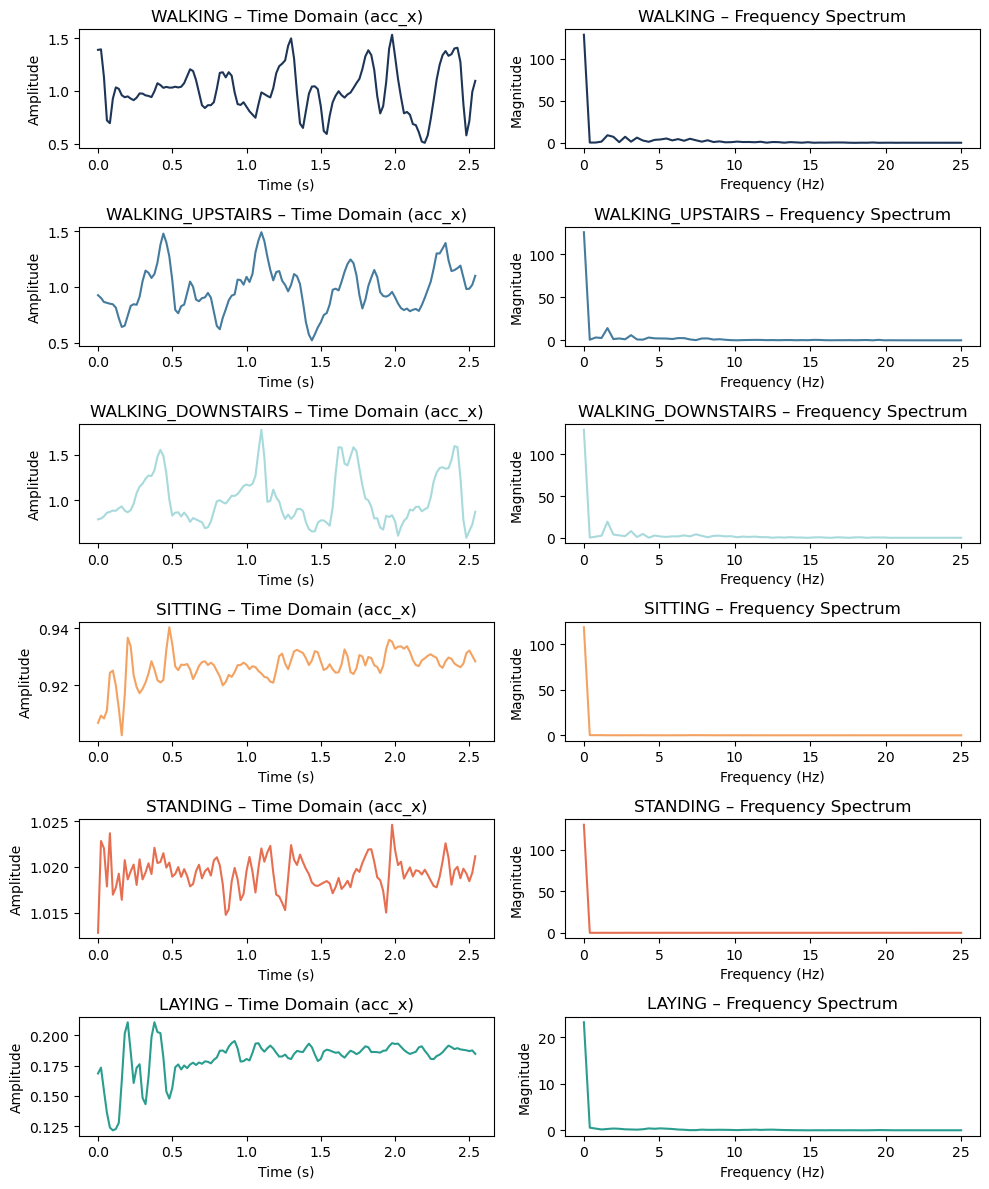

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Load UCI HAR dataset (same structure as before) ---
uci_root = "UCIHARDataset" 
signal_names = [
    "total_acc_x_", "total_acc_y_", "total_acc_z_",
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_"
]

def load_uci_split(root, split="train"):
    folder = os.path.join(root, split, "Inertial Signals")
    arrays = [np.loadtxt(os.path.join(folder, f"{s}{split}.txt")) for s in signal_names]
    data = np.stack(arrays, axis=-1)  # [N, T, 9]
    labels = np.loadtxt(os.path.join(root, split, f"y_{split}.txt")).astype(int)
    return data, labels

X_train_uci, y_train_uci = load_uci_split(uci_root, "train")
print("UCI HAR Loaded:", X_train_uci.shape, "Labels:", np.unique(y_train_uci))

# --- Activity labels (UCI HAR) ---
ACTIVITIES = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

fs = 50  # 50 Hz sampling rate
colors = ["#1D3557", "#457B9D", "#A8DADC", "#F4A261", "#E76F51", "#2A9D8F"]

# --- Function to visualize one sample per UCI activity ---
def plot_uci_examples(X, y, fs=50):
    fig, axes = plt.subplots(6, 2, figsize=(10, 12))
    plt.subplots_adjust(hspace=0.5)

    for i, label in enumerate(np.unique(y)):
        idx = np.where(y == label)[0][0]
        signal = X[idx, :, 0]  # first channel (x-axis)
        t = np.arange(len(signal)) / fs

        # Time-domain
        axes[i, 0].plot(t, signal, color=colors[i])
        axes[i, 0].set_title(f"{ACTIVITIES[label-1]} – Time Domain (acc_x)")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("Amplitude")

        # Frequency-domain
        freq = np.fft.rfftfreq(len(signal), 1/fs)
        mag = np.abs(np.fft.rfft(signal))
        axes[i, 1].plot(freq, mag, color=colors[i])
        axes[i, 1].set_title(f"{ACTIVITIES[label-1]} – Frequency Spectrum")
        axes[i, 1].set_xlabel("Frequency (Hz)")
        axes[i, 1].set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

# --- Run visualization ---
plot_uci_examples(X_train_uci, y_train_uci, fs)


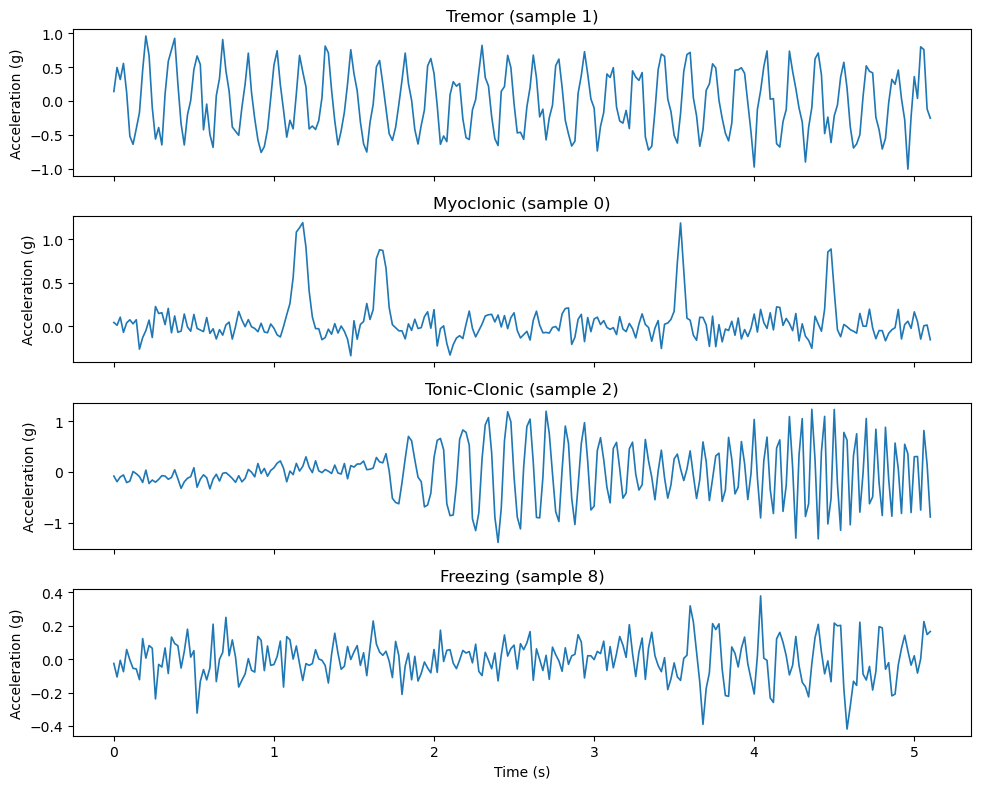

In [1]:
import matplotlib.pyplot as plt
import numpy as np, os

# Root directory (adjust if needed)
root = "Simulations/train"

# Load labels (1-indexed like UCI HAR)
y = np.loadtxt(os.path.join(root.replace("train",""), "train", "y_train.txt")).astype(int)

# Load total acceleration (x-axis) signal
sig = np.loadtxt(os.path.join(root, "total_acc_x_train.txt"))

# Define class names (aligned with label encoding)
classes = ["Tremor", "Myoclonic", "Tonic-Clonic", "Freezing"]
fs = 50  # sampling frequency

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

for i in range(1, 5):  # labels 1–4
    idx = np.where(y == i)[0][0]
    t = np.arange(sig.shape[1]) / fs
    axes[i-1].plot(t, sig[idx], linewidth=1.2)
    axes[i-1].set_title(f"{classes[i-1]} (sample {idx})")
    axes[i-1].set_ylabel("Acceleration (g)")
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
